In [284]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [285]:
# set seed
seed_value = 42
torch.manual_seed(seed_value)
random.seed(seed_value)

In [286]:
# Import Data
data = pd.read_csv('dataset.csv')

In [287]:
# dropping NA values
df = data.dropna()
print(df.shape)
df[0:5]

(766, 8)


,f1,f2,f3,f4,f5,f6,f7,target
0,6,148,72,35,0,33.6,0.627,1
1,1,85,66,29,0,26.6,0.351,0
2,8,183,64,0,0,23.3,0.672,1
3,1,89,66,23,94,28.1,0.167,0
4,0,137,40,35,168,43.1,2.288,1


In [288]:
# drop non-numeric values from other attributes

df = df.drop(df[df['f1'] == 'c'].index)
df = df.drop(df[df['f2'] == 'f'].index)
df = df.drop(df[df['f4'] == 'a'].index)
df = df.drop(df[df['f5'] == 'b'].index)
df = df.drop(df[df['f6'] == 'd'].index)
df = df.drop(df[df['f7'] == 'e'].index)

print(df.shape)
df[0:5]

(760, 8)


,f1,f2,f3,f4,f5,f6,f7,target
0,6,148,72,35,0,33.6,0.627,1
1,1,85,66,29,0,26.6,0.351,0
2,8,183,64,0,0,23.3,0.672,1
3,1,89,66,23,94,28.1,0.167,0
4,0,137,40,35,168,43.1,2.288,1


In [289]:
# Scale numerical variables to have zero mean and unit variance.
# use StandardScaler

#scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)
input_features = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']

# transform
df_num = df[input_features]
scaler.fit(df_num)
scaled_data = scaler.transform(df_num) 

# create scaled DF
scaled_df = pd.DataFrame(scaled_data, columns=input_features)
scaled_df.head()

# replace original numerical columns in the original DF with scaled ones
df[input_features] = scaled_df
df.head()

# pre-processing done

,f1,f2,f3,f4,f5,f6,f7,target
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,1
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,1
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,1


In [290]:
# define Inputs and Output

X_in = df[input_features]
y_out = df['target']
print('Size of X:', X_in.shape)
print('Size of y:', y_out.shape)
X_in.head()

Size of X: (760, 7)
Size of y: (760,)


,f1,f2,f3,f4,f5,f6,f7
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638


In [293]:
# Split Training and Testing data
# X is the input data and y is the target variable
X_train, X_test, y_train, y_test = train_test_split(X_in, y_out, test_size=0.2, random_state = 42)

print("X_train size:", X_train.shape)
print("y_train size:", y_train.shape)
print("X_test size:", X_test.shape)
print("y_test size:", y_test.shape) 

print(X_train.head())
print(X_test.head())
print(y_train.head())
print(y_test.head())

X_train size: (608, 7)
y_train size: (608,)
X_test size: (152, 7)
y_test size: (152,)
           f1        f2        f3        f4        f5        f6        f7
693  0.411765  0.648241  0.557377  0.494949  0.147754  0.573770  0.154142
361  0.294118  0.793970  0.573770  0.000000  0.000000  0.444113  0.055081
266  0.000000  0.693467  0.000000  0.000000  0.000000  0.540984  0.365073
90   0.058824  0.402010  0.450820  0.000000  0.000000  0.284650  0.076857
368  0.176471  0.407035  0.704918  0.161616  0.078014  0.409836  0.097353
           f1        f2        f3        f4        f5        f6        f7
395  0.117647  0.638191  0.475410  0.242424  0.325059  0.412817  0.649872
324  0.117647  0.562814  0.614754  0.323232  0.000000  0.532042  0.029889
97   0.058824  0.356784  0.393443  0.181818  0.089835  0.304024  0.104611
497  0.117647  0.407035  0.590164  0.151515  0.089835  0.448584  0.200256
109  0.000000  0.477387  0.696721  0.252525  0.042553  0.557377  0.072161
693    1
361    0
266    1

In [294]:
# convert DF to PyTorch tensor
X_train_tensor = torch.tensor(X_train.values)
X_test_tensor = torch.tensor(X_test.values)

y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)

print(X_train_tensor.dtype)
print(X_test_tensor.dtype)
print(y_train_tensor.dtype)
print(y_test_tensor.dtype)

print(X_train_tensor[0:4])

torch.float64
torch.float64
torch.int64
torch.int64
tensor([[0.4118, 0.6482, 0.5574, 0.4949, 0.1478, 0.5738, 0.1541],
        [0.2941, 0.7940, 0.5738, 0.0000, 0.0000, 0.4441, 0.0551],
        [0.0000, 0.6935, 0.0000, 0.0000, 0.0000, 0.5410, 0.3651],
        [0.0588, 0.4020, 0.4508, 0.0000, 0.0000, 0.2846, 0.0769]],
       dtype=torch.float64)


In [295]:
# making tensors
# convert dtype for y (to prevent the error): RuntimeError: mat1 and mat2 must have the same dtype
y_train_tensor = y_train_tensor.to(dtype=torch.float64)
y_test_tensor = y_test_tensor.to(dtype=torch.float64)

print(y_train_tensor.dtype)
print(y_test_tensor.dtype)

torch.float64
torch.float64


In [296]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_i = self.X[idx]
        y_i = self.y[idx]
        return x_i, y_i  


In [298]:
# Create a dataset instance
train_dataset = MyDataset(X_train_tensor, y_train_tensor)
test_dataset = MyDataset(X_test_tensor, y_test_tensor)

print(X_train_tensor.dtype)
print(y_train_tensor.dtype)
print(X_test_tensor.dtype)
print(y_test_tensor.dtype)

#print(X_train_tensor[(0,1), :])
print(X_train_tensor[0:4])
#print(X_train_tensor[:2])

torch.float64
torch.float64
torch.float64
torch.float64
tensor([[0.4118, 0.6482, 0.5574, 0.4949, 0.1478, 0.5738, 0.1541],
        [0.2941, 0.7940, 0.5738, 0.0000, 0.0000, 0.4441, 0.0551],
        [0.0000, 0.6935, 0.0000, 0.0000, 0.0000, 0.5410, 0.3651],
        [0.0588, 0.4020, 0.4508, 0.0000, 0.0000, 0.2846, 0.0769]],
       dtype=torch.float64)


In [304]:
# Create data loaders for datasets 
# shuffle for training, not for validation

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 16, shuffle=True) # 32, 64, 38
#test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 38, shuffle=False) # 8, 16, 38

print('Training set has {} instances'.format(len(train_dataloader)))
print('Validation set has {} instances'.format(len(test_dataset)))

#for idx, (X, y) in enumerate(test_dataset):
#  print(idx, y)

Training set has 38 instances
Validation set has 152 instances


In [323]:
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super(NeuralNetwork, self).__init__()
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(7, 128),
#             nn.ReLU(),
#             nn.Linear(128, 128),
#             nn.ReLU(),
#             nn.Linear(128, 1),
#             nn.Sigmoid()
#         )
#     def forward(self, x):
#         logits = self.linear_relu_stack(x)
#         return logits

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = NeuralNetwork().to(device)
# print(model)
# device


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNetwork().to(device)
print(model)
device

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


device(type='cpu')

In [324]:
# define training and testing loops

def train_loop(dataloader, model, loss_fn, optimizer, train_losses, train_acc_history):
  train_loss, ones = 0.0, 0
  pred_out = []                                   # list that will contain 0 or 1 based on incorrect/correct prediction
  size = len(dataloader.dataset)
  predictions_train = []                          # to collect predictions
  
  for batch, (X, y) in enumerate(dataloader):
    # calculate predictions
    X = X.to(next(model.parameters()).dtype)      # Convert X tensor to same data type as model weights and biases
    pred = model(X)
    predictions_train.append(pred)
    pred = pred.to(torch.float64)                 # Convert to float 64, by default it was float32
    
    # calculate loss
    y = y.view(-1, 1)  # reshape to [38, 1]       # Reshape target tensor to have same shape as predicted output tensor
    loss = loss_fn(pred, y)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    if batch % 4 == 0:                            # aesthetics for output
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f'Train loss: {loss:>7f} in Batch: {batch:2d}  [{current:>5d}/{size:>5d}]')

  merged_predictions_train_tensor = torch.cat(predictions_train, dim=0)         # merge predictions for all batches
  for ele in merged_predictions_train_tensor:                                   # calculate correct predictions                              
    if ele >= 0.5:
      pred_out.append(1)
    else:
      pred_out.append(0)

  for idx, ele in enumerate(y_test_tensor):
     if ele == pred_out[idx]:
       ones += 1

  accuracy = 100*ones/size
  train_acc_history.append(accuracy)
  avg_train_loss = train_loss / size
  print(f'Train Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Train loss: {avg_train_loss:.4f} \n')
  train_losses.append(avg_train_loss)

def test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history):
  size = len(test_dataset)
  test_loss, correct, ones = 0, 0, 0
  predictions = []                              # to collect predictions

  with torch.no_grad():
    for X, y in test_dataset:      
      # calculate and collect predictions
      X = X.to(next(model.parameters()).dtype)  # Convert X tensor to same data type as model weights and biases
      pred = model(X)
      # print('testing pred:', pred)                               
      predictions.append(pred)          
      pred = pred.to(torch.float64)             # Convert to float 64, by default it was float32

      # calculate loss
      y = y.view(-1)                            # Reshape target tensor to have same shape as predicted output tensor
      loss = loss_fn(pred, y)
      test_loss += loss.item()
    
    avg_test_loss = (test_loss / size)          # test loss
    pred_out = []                               # list that will contain 0 or 1 based on incorrect/correct prediction

    for ele in predictions:                     # calculate correct predictions
      if ele >= 0.5:
        pred_out.append(1)
      else:
        pred_out.append(0)

    for idx, ele in enumerate(y_test_tensor):
      if ele == pred_out[idx]:
        ones += 1
    
    accuracy = 100*ones/size
    test_acc_history.append(accuracy)

    # store for comparision in confusion matrix
    global y_pred
    y_pred = pred_out
    print(f'Test Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Test loss: {avg_test_loss:.4f} \n')

  test_losses.append(avg_test_loss)
  return accuracy

In [326]:
# Run model for epochs

epochs, max_acc = 100, 0
train_losses, test_losses = [], []                        # Initialize lists to store losses
train_acc_history, test_acc_history = [], []              # Initialize lists to store accuracy values
loss_fn = nn.BCELoss()                                    # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # optimizer

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, train_losses, train_acc_history)
    accuracy = test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history)
    if accuracy > max_acc:                                # store max accuracy for testing
      max_acc = accuracy

print("Done!")
print(f'Max accuracy: {max_acc}')

Epoch 1
-------------------------------
Train loss: 0.431695 in Batch:  0  [   16/  608]
Train loss: 0.581153 in Batch:  4  [   80/  608]
Train loss: 0.430882 in Batch:  8  [  144/  608]
Train loss: 0.398608 in Batch: 12  [  208/  608]
Train loss: 0.439457 in Batch: 16  [  272/  608]
Train loss: 0.477137 in Batch: 20  [  336/  608]
Train loss: 0.444101 in Batch: 24  [  400/  608]
Train loss: 0.478779 in Batch: 28  [  464/  608]
Train loss: 0.460706 in Batch: 32  [  528/  608]
Train loss: 0.766126 in Batch: 36  [  592/  608]
Train Accuracy: 93/608 (15.30%), Avg Train loss: 0.0310 

Test Accuracy: 112/152 (73.68%), Avg Test loss: 0.5264 

Epoch 2
-------------------------------
Train loss: 0.561342 in Batch:  0  [   16/  608]
Train loss: 0.498703 in Batch:  4  [   80/  608]
Train loss: 0.445998 in Batch:  8  [  144/  608]
Train loss: 0.481463 in Batch: 12  [  208/  608]
Train loss: 0.629036 in Batch: 16  [  272/  608]
Train loss: 0.410854 in Batch: 20  [  336/  608]
Train loss: 0.378314 

In [327]:
# save weights
import h5py
# Save the model weights to an HDF5 file
with h5py.File('rishabhv_nihareek_assignment2_part1.h5', 'w') as f:
    for name, param in model.named_parameters():
        f.create_dataset(name, data=param.detach().numpy())


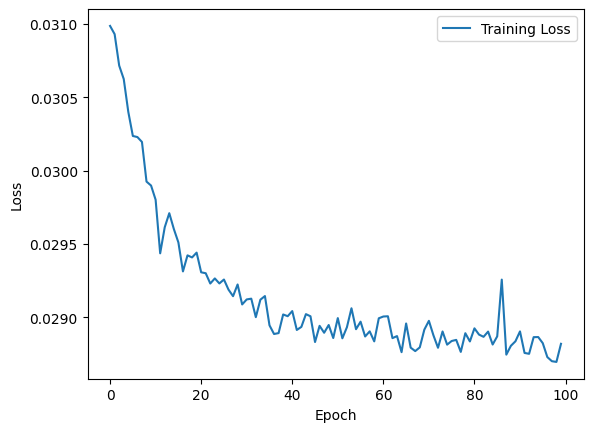

In [328]:
# plot Train loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

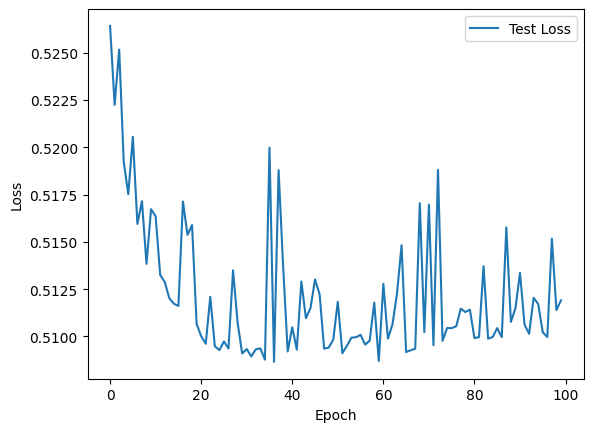

In [329]:
# plot Test Loss
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

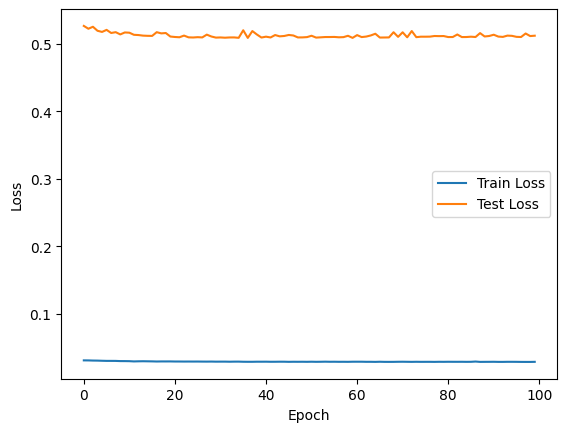

In [330]:
# plot Training and Testing loss on the same plot
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

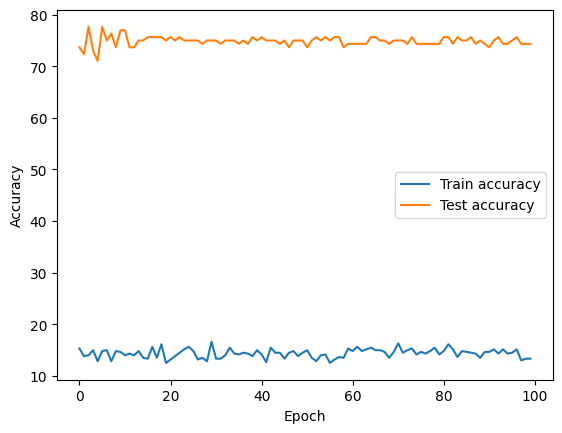

In [331]:
# Plot the accuracy curve
plt.plot(train_acc_history, label='Train accuracy')
plt.plot(test_acc_history, label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

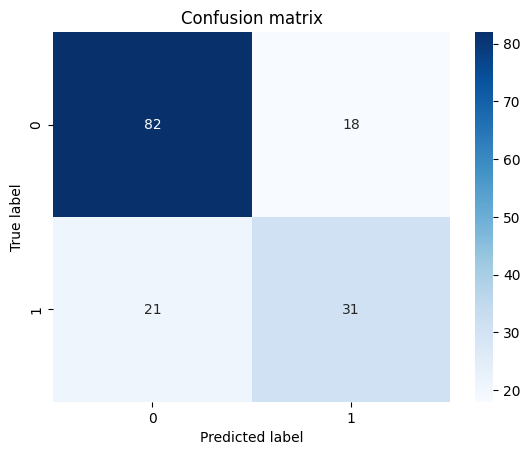

In [332]:
# Calculate confusion matrix
cm = confusion_matrix(y_test_tensor, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')           # Visualize the confusion matrix using a heatmap
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

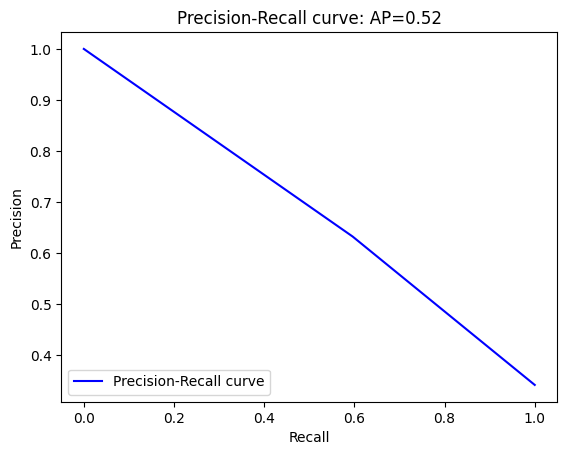

In [333]:
# precision-recall curve and average precision score
precision, recall, thresholds = precision_recall_curve(y_test_tensor, y_pred)
average_precision = average_precision_score(y_test_tensor, y_pred)

# Plot
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.legend(loc='lower left')
plt.show()

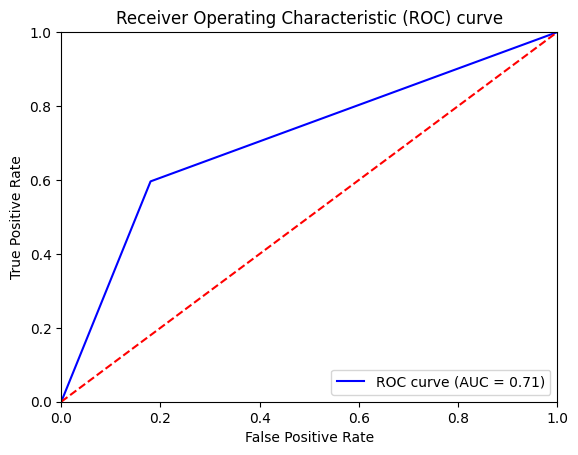

In [334]:
# Calculate ROC and area under curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test_tensor, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.plot(fpr, tpr, 'b', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

# PART 2

In [336]:
## Implementing 'dropout' with probability 0.5
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 64),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [337]:
## dropout with probability 0.5
# define training and testing loops

def train_loop(dataloader, model, loss_fn, optimizer, train_losses, train_acc_history):
  train_loss, ones = 0.0, 0
  pred_out = []                                   # list that will contain 0 or 1 based on incorrect/correct prediction
  size = len(dataloader.dataset)
  predictions_train = []                          # to collect predictions
  
  for batch, (X, y) in enumerate(dataloader):
    # calculate predictions
    X = X.to(next(model.parameters()).dtype)      # Convert X tensor to same data type as model weights and biases
    pred = model(X)
    predictions_train.append(pred)
    pred = pred.to(torch.float64)                 # Convert to float 64, by default it was float32
    
    # calculate loss
    y = y.view(-1, 1)  # reshape to [38, 1]       # Reshape target tensor to have same shape as predicted output tensor
    loss = loss_fn(pred, y)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    if batch % 3 == 0:                            # aesthetics for output
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f'Train loss: {loss:>7f} in Batch: {batch:2d}  [{current:>5d}/{size:>5d}]')

  merged_predictions_train_tensor = torch.cat(predictions_train, dim=0)         # merge predictions for all batches
  for ele in merged_predictions_train_tensor:                                   # calculate correct predictions                              
    if ele >= 0.5:
      pred_out.append(1)
    else:
      pred_out.append(0)

  for idx, ele in enumerate(y_test_tensor):
     if ele == pred_out[idx]:
       ones += 1

  accuracy = 100*ones/size
  train_acc_history.append(accuracy)

  avg_train_loss = train_loss / size
  print(f'Train Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Train loss: {avg_train_loss:.4f} \n')
  train_losses.append(avg_train_loss)

def test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history):
  size = len(test_dataset)
  test_loss, correct, ones = 0, 0, 0
  predictions = []                              # to collect predictions

  with torch.no_grad():
    for X, y in test_dataset:      
      # calculate and collect predictions
      X = X.to(next(model.parameters()).dtype)  # Convert X tensor to same data type as model weights and biases
      pred = model(X)
      # print('testing pred:', pred)                               
      predictions.append(pred)          
      pred = pred.to(torch.float64)             # Convert to float 64, by default it was float32

      # calculate loss
      y = y.view(-1)                            # Reshape target tensor to have same shape as predicted output tensor
      loss = loss_fn(pred, y)
      test_loss += loss.item()
    
    avg_test_loss = (test_loss / size)          # test loss
    pred_out = []                               # list that will contain 0 or 1 based on incorrect/correct prediction

    for ele in predictions:                     # calculate correct predictions
      if ele >= 0.5:
        pred_out.append(1)
      else:
        pred_out.append(0)

    for idx, ele in enumerate(y_test_tensor):
      if ele == pred_out[idx]:
        ones += 1
    
    accuracy = 100*ones/size
    test_acc_history.append(accuracy)

    # store for comparision in confusion matrix
    global y_pred
    y_pred = pred_out
    print(f'Test Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Test loss: {avg_test_loss:.4f} \n')
     
  test_losses.append(avg_test_loss)
  return accuracy

In [339]:
## dropout with probability 0.5
# Run model for epochs
epochs, max_acc = 100, 0
train_losses, test_losses = [], []                        # Initialize lists to store losses
train_acc_history, test_acc_history = [], []              # Initialize lists to store accuracy values
loss_fn = nn.BCELoss()                                    # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # optimizer

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, train_losses, train_acc_history)
    accuracy = test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history)
    if accuracy > max_acc:                                # store max accuracy for testing
      max_acc = accuracy

print("Done!")
print(f'Max accuracy: {max_acc}')

Epoch 1
-------------------------------
Train loss: 0.643782 in Batch:  0  [   16/  608]
Train loss: 0.602102 in Batch:  3  [   64/  608]
Train loss: 0.610000 in Batch:  6  [  112/  608]
Train loss: 0.525022 in Batch:  9  [  160/  608]
Train loss: 0.630273 in Batch: 12  [  208/  608]
Train loss: 0.614731 in Batch: 15  [  256/  608]
Train loss: 0.665739 in Batch: 18  [  304/  608]
Train loss: 0.554549 in Batch: 21  [  352/  608]
Train loss: 0.710880 in Batch: 24  [  400/  608]
Train loss: 0.546771 in Batch: 27  [  448/  608]
Train loss: 0.509763 in Batch: 30  [  496/  608]
Train loss: 0.575170 in Batch: 33  [  544/  608]
Train loss: 0.566318 in Batch: 36  [  592/  608]
Train Accuracy: 99/608 (16.28%), Avg Train loss: 0.0393 

Test Accuracy: 100/152 (65.79%), Avg Test loss: 0.6279 

Epoch 2
-------------------------------
Train loss: 0.596340 in Batch:  0  [   16/  608]
Train loss: 0.601583 in Batch:  3  [   64/  608]
Train loss: 0.576123 in Batch:  6  [  112/  608]
Train loss: 0.650266 

In [340]:
## dropout with probability 0.25
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 64),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNetwork().to(device)
print(model)
device

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): Dropout(p=0.25, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): Dropout(p=0.25, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


device(type='cpu')

In [341]:
## dropout with probability 0.25
# define training and testing loops

def train_loop(dataloader, model, loss_fn, optimizer, train_losses, train_acc_history):
  train_loss, ones = 0.0, 0
  pred_out = []                                   # list that will contain 0 or 1 based on incorrect/correct prediction
  size = len(dataloader.dataset)
  predictions_train = []                          # to collect predictions
  
  for batch, (X, y) in enumerate(dataloader):
    # calculate predictions
    X = X.to(next(model.parameters()).dtype)      # Convert X tensor to same data type as model weights and biases
    pred = model(X)
    predictions_train.append(pred)
    pred = pred.to(torch.float64)                 # Convert to float 64, by default it was float32
    
    # calculate loss
    y = y.view(-1, 1)  # reshape to [38, 1]       # Reshape target tensor to have same shape as predicted output tensor
    loss = loss_fn(pred, y)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    if batch % 3 == 0:                            # aesthetics for output
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f'Train loss: {loss:>7f} in Batch: {batch:2d}  [{current:>5d}/{size:>5d}]')

  merged_predictions_train_tensor = torch.cat(predictions_train, dim=0)         # merge predictions for all batches
  for ele in merged_predictions_train_tensor:                                   # calculate correct predictions                              
    if ele >= 0.5:
      pred_out.append(1)
    else:
      pred_out.append(0)

  for idx, ele in enumerate(y_test_tensor):
     if ele == pred_out[idx]:
       ones += 1

  accuracy = 100*ones/size
  train_acc_history.append(accuracy)

  avg_train_loss = train_loss / size
  print(f'Train Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Train loss: {avg_train_loss:.4f} \n')
  train_losses.append(avg_train_loss)

def test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history):
  size = len(test_dataset)
  test_loss, correct, ones = 0, 0, 0
  predictions = []                              # to collect predictions

  with torch.no_grad():
    for X, y in test_dataset:      
      # calculate and collect predictions
      X = X.to(next(model.parameters()).dtype)  # Convert X tensor to same data type as model weights and biases
      pred = model(X)
      # print('testing pred:', pred)                               
      predictions.append(pred)          
      pred = pred.to(torch.float64)             # Convert to float 64, by default it was float32

      # calculate loss
      y = y.view(-1)                            # Reshape target tensor to have same shape as predicted output tensor
      loss = loss_fn(pred, y)
      test_loss += loss.item()
    
    avg_test_loss = (test_loss / size)          # test loss
    pred_out = []                               # list that will contain 0 or 1 based on incorrect/correct prediction

    for ele in predictions:                     # calculate correct predictions
      if ele >= 0.5:
        pred_out.append(1)
      else:
        pred_out.append(0)

    for idx, ele in enumerate(y_test_tensor):
      if ele == pred_out[idx]:
        ones += 1
    
    accuracy = 100*ones/size
    test_acc_history.append(accuracy)

    # store for comparision in confusion matrix
    global y_pred
    y_pred = pred_out
    print(f'Test Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Test loss: {avg_test_loss:.4f} \n')
     
  test_losses.append(avg_test_loss)
  return accuracy

In [342]:
## dropout with probability 0.25

epochs, max_acc = 100, 0
train_losses, test_losses = [], []                        # Initialize lists to store losses
train_acc_history, test_acc_history = [], []              # Initialize lists to store accuracy values
loss_fn = nn.BCELoss()                                    # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # optimizer

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, train_losses, train_acc_history)
    accuracy = test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history)
    if accuracy > max_acc:                                # store max accuracy for testing
      max_acc = accuracy

print("Done!")
print(f'Max accuracy: {max_acc}')

Epoch 1
-------------------------------
Train loss: 0.694065 in Batch:  0  [   16/  608]
Train loss: 0.688527 in Batch:  3  [   64/  608]
Train loss: 0.680518 in Batch:  6  [  112/  608]
Train loss: 0.688494 in Batch:  9  [  160/  608]
Train loss: 0.687207 in Batch: 12  [  208/  608]
Train loss: 0.687178 in Batch: 15  [  256/  608]
Train loss: 0.686395 in Batch: 18  [  304/  608]
Train loss: 0.697466 in Batch: 21  [  352/  608]
Train loss: 0.689143 in Batch: 24  [  400/  608]
Train loss: 0.688456 in Batch: 27  [  448/  608]
Train loss: 0.702437 in Batch: 30  [  496/  608]
Train loss: 0.685795 in Batch: 33  [  544/  608]
Train loss: 0.674239 in Batch: 36  [  592/  608]
Train Accuracy: 90/608 (14.80%), Avg Train loss: 0.0429 

Test Accuracy: 100/152 (65.79%), Avg Test loss: 0.6816 

Epoch 2
-------------------------------
Train loss: 0.686331 in Batch:  0  [   16/  608]
Train loss: 0.673562 in Batch:  3  [   64/  608]
Train loss: 0.699448 in Batch:  6  [  112/  608]
Train loss: 0.668833 

In [175]:
## dropout with probability 0.75
class NeuralNetwork(nn.Module):  
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 128),
            nn.Dropout(0.75),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(0.75),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNetwork().to(device)
print(model)
device

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): Dropout(p=0.75, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Dropout(p=0.75, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


device(type='cpu')

In [176]:
## dropout with probability 0.75
# define training and testing loops

def train_loop(dataloader, model, loss_fn, optimizer, train_losses, train_acc_history):
  train_loss, ones = 0.0, 0
  pred_out = []                                   # list that will contain 0 or 1 based on incorrect/correct prediction
  size = len(dataloader.dataset)
  predictions_train = []                          # to collect predictions
  
  for batch, (X, y) in enumerate(dataloader):
    # calculate predictions
    X = X.to(next(model.parameters()).dtype)      # Convert X tensor to same data type as model weights and biases
    pred = model(X)
    predictions_train.append(pred)
    pred = pred.to(torch.float64)                 # Convert to float 64, by default it was float32
    
    # calculate loss
    y = y.view(-1, 1)  # reshape to [38, 1]       # Reshape target tensor to have same shape as predicted output tensor
    loss = loss_fn(pred, y)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    if batch % 3 == 0:                            # aesthetics for output
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f'Train loss: {loss:>7f} in Batch: {batch:2d}  [{current:>5d}/{size:>5d}]')

  merged_predictions_train_tensor = torch.cat(predictions_train, dim=0)         # merge predictions for all batches
  for ele in merged_predictions_train_tensor:                                   # calculate correct predictions                              
    if ele >= 0.5:
      pred_out.append(1)
    else:
      pred_out.append(0)

  for idx, ele in enumerate(y_test_tensor):
     if ele == pred_out[idx]:
       ones += 1

  accuracy = 100*ones/size
  train_acc_history.append(accuracy)

  avg_train_loss = train_loss / size
  print(f'Train Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Train loss: {avg_train_loss:.4f} \n')
  train_losses.append(avg_train_loss)

def test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history):
  size = len(test_dataset)
  test_loss, correct, ones = 0, 0, 0
  predictions = []                              # to collect predictions

  with torch.no_grad():
    for X, y in test_dataset:      
      # calculate and collect predictions
      X = X.to(next(model.parameters()).dtype)  # Convert X tensor to same data type as model weights and biases
      pred = model(X)
      # print('testing pred:', pred)                               
      predictions.append(pred)          
      pred = pred.to(torch.float64)             # Convert to float 64, by default it was float32

      # calculate loss
      y = y.view(-1)                            # Reshape target tensor to have same shape as predicted output tensor
      loss = loss_fn(pred, y)
      test_loss += loss.item()
    
    avg_test_loss = (test_loss / size)          # test loss
    pred_out = []                               # list that will contain 0 or 1 based on incorrect/correct prediction

    for ele in predictions:                     # calculate correct predictions
      if ele >= 0.5:
        pred_out.append(1)
      else:
        pred_out.append(0)

    for idx, ele in enumerate(y_test_tensor):
      if ele == pred_out[idx]:
        ones += 1
    
    accuracy = 100*ones/size
    test_acc_history.append(accuracy)

    # store for comparision in confusion matrix
    global y_pred
    y_pred = pred_out
    print(f'Test Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Test loss: {avg_test_loss:.4f} \n')
     
  test_losses.append(avg_test_loss)
  return accuracy

In [ ]:
## dropout with probability 0.75
# Run model for epochs
epochs, max_acc = 100, 0
train_losses, test_losses = [], []                        # Initialize lists to store losses
train_acc_history, test_acc_history = [], []              # Initialize lists to store accuracy values
loss_fn = nn.BCELoss()                                    # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # optimizer

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, train_losses, train_acc_history)
    accuracy = test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history)
    if accuracy > max_acc:                                # store max accuracy for testing
      max_acc = accuracy

print("Done!")
print(f'Max accuracy: {max_acc}')

In [178]:
## Step 2 
# “Optimizer” Tuning (RMSprop)
# dropout with probability 0.5
class NeuralNetwork(nn.Module):  
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNetwork().to(device)
print(model)
device

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


device(type='cpu')

In [ ]:
## Step 2 
# “Optimizer” Tuning (RMSprop)
# dropout with probability 0.5
# Run model for epochs
epochs, max_acc = 100, 0
train_losses, test_losses = [], []                        # Initialize lists to store losses
train_acc_history, test_acc_history = [], []              # Initialize lists to store accuracy values
loss_fn = nn.BCELoss()                                    # loss function
optimizer = optim.RMSprop(model.parameters(), lr=0.01)    # optimizer

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, train_losses, train_acc_history)
    accuracy = test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history)
    if accuracy > max_acc:                                # store max accuracy for testing
      max_acc = accuracy

print("Done!")
print(f'Max accuracy: {max_acc}')

In [ ]:
## Step 2 
# “Optimizer” Tuning (Adam)
# dropout with probability 0.5
# Run model for epochs
epochs, max_acc = 100, 0
train_losses, test_losses = [], []                        # Initialize lists to store losses
train_acc_history, test_acc_history = [], []              # Initialize lists to store accuracy values
loss_fn = nn.BCELoss()                                    # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # optimizer

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, train_losses, train_acc_history)
    accuracy = test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history)
    if accuracy > max_acc:                                # store max accuracy for testing
      max_acc = accuracy

print("Done!")
print(f'Max accuracy: {max_acc}')

In [ ]:
## Step 2 
# “Activation Function” Tuning (LeakyReLU, slope = 0.02)
# dropout with probability 0.5
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 128),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.02),
            nn.Linear(128, 128),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.02),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNetwork().to(device)
print(model)
device

In [191]:
## Step 2 
# “Activation Function” Tuning (LeakyReLU, slope = 0.02)
# dropout with probability 0.5
# define training and testing loops
# define training and testing loops

def train_loop(dataloader, model, loss_fn, optimizer, train_losses, train_acc_history):
  train_loss, ones = 0.0, 0
  pred_out = []                                   # list that will contain 0 or 1 based on incorrect/correct prediction
  size = len(dataloader.dataset)
  predictions_train = []                          # to collect predictions
  
  for batch, (X, y) in enumerate(dataloader):
    # calculate predictions
    X = X.to(next(model.parameters()).dtype)      # Convert X tensor to same data type as model weights and biases
    pred = model(X)
    predictions_train.append(pred)
    pred = pred.to(torch.float64)                 # Convert to float 64, by default it was float32
    
    # calculate loss
    y = y.view(-1, 1)  # reshape to [38, 1]       # Reshape target tensor to have same shape as predicted output tensor
    loss = loss_fn(pred, y)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    if batch % 3 == 0:                            # aesthetics for output
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f'Train loss: {loss:>7f} in Batch: {batch:2d}  [{current:>5d}/{size:>5d}]')

  merged_predictions_train_tensor = torch.cat(predictions_train, dim=0)         # merge predictions for all batches
  for ele in merged_predictions_train_tensor:                                   # calculate correct predictions                              
    if ele >= 0.5:
      pred_out.append(1)
    else:
      pred_out.append(0)

  for idx, ele in enumerate(y_test_tensor):
     if ele == pred_out[idx]:
       ones += 1

  accuracy = 100*ones/size
  train_acc_history.append(accuracy)

  avg_train_loss = train_loss / size
  print(f'Train Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Train loss: {avg_train_loss:.4f} \n')
  train_losses.append(avg_train_loss)

def test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history):
  size = len(test_dataset)
  test_loss, correct, ones = 0, 0, 0
  predictions = []                              # to collect predictions

  with torch.no_grad():
    for X, y in test_dataset:      
      # calculate and collect predictions
      X = X.to(next(model.parameters()).dtype)  # Convert X tensor to same data type as model weights and biases
      pred = model(X)
      # print('testing pred:', pred)                               
      predictions.append(pred)          
      pred = pred.to(torch.float64)             # Convert to float 64, by default it was float32

      # calculate loss
      y = y.view(-1)                            # Reshape target tensor to have same shape as predicted output tensor
      loss = loss_fn(pred, y)
      test_loss += loss.item()
    
    avg_test_loss = (test_loss / size)          # test loss
    pred_out = []                               # list that will contain 0 or 1 based on incorrect/correct prediction

    for ele in predictions:                     # calculate correct predictions
      if ele >= 0.5:
        pred_out.append(1)
      else:
        pred_out.append(0)

    for idx, ele in enumerate(y_test_tensor):
      if ele == pred_out[idx]:
        ones += 1
    
    accuracy = 100*ones/size
    test_acc_history.append(accuracy)

    # store for comparision in confusion matrix
    global y_pred
    y_pred = pred_out
    print(f'Test Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Test loss: {avg_test_loss:.4f} \n')
     
  test_losses.append(avg_test_loss)
  return accuracy

In [ ]:
## Step 2 
# “Activation Function” Tuning (LeakyReLU, slope = 0.02)
# dropout with probability 0.5
# Run model for epochs

epochs, max_acc = 100, 0
train_losses, test_losses = [], []                        # Initialize lists to store losses
train_acc_history, test_acc_history = [], []              # Initialize lists to store accuracy values
loss_fn = nn.BCELoss()                                    # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # optimizer

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, train_losses, train_acc_history)
    accuracy = test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history)
    if accuracy > max_acc:                                # store max accuracy for testing
      max_acc = accuracy

print("Done!")
print(f'Max accuracy: {max_acc}')

In [ ]:
## Step 2 
# “Activation Function” Tuning (ELU)
# dropout with probability 0.5
class NeuralNetwork(nn.Module):  
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 128),
            nn.Dropout(0.5),
            nn.ELU(),
            nn.Linear(128, 128),
            nn.Dropout(0.5),
            nn.ELU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNetwork().to(device)
print(model)
device

In [188]:
## Step 2 
# “Activation Function” Tuning (ELU)
# dropout with probability 0.5
# define training and testing loops

def train_loop(dataloader, model, loss_fn, optimizer, train_losses, train_acc_history):
  train_loss, ones = 0.0, 0
  pred_out = []                                   # list that will contain 0 or 1 based on incorrect/correct prediction
  size = len(dataloader.dataset)
  predictions_train = []                          # to collect predictions
  
  for batch, (X, y) in enumerate(dataloader):
    # calculate predictions
    X = X.to(next(model.parameters()).dtype)      # Convert X tensor to same data type as model weights and biases
    pred = model(X)
    predictions_train.append(pred)
    pred = pred.to(torch.float64)                 # Convert to float 64, by default it was float32
    
    # calculate loss
    y = y.view(-1, 1)  # reshape to [38, 1]       # Reshape target tensor to have same shape as predicted output tensor
    loss = loss_fn(pred, y)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    if batch % 3 == 0:                            # aesthetics for output
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f'Train loss: {loss:>7f} in Batch: {batch:2d}  [{current:>5d}/{size:>5d}]')

  merged_predictions_train_tensor = torch.cat(predictions_train, dim=0)         # merge predictions for all batches
  for ele in merged_predictions_train_tensor:                                   # calculate correct predictions                              
    if ele >= 0.5:
      pred_out.append(1)
    else:
      pred_out.append(0)

  for idx, ele in enumerate(y_test_tensor):
     if ele == pred_out[idx]:
       ones += 1

  accuracy = 100*ones/size
  train_acc_history.append(accuracy)

  avg_train_loss = train_loss / size
  print(f'Train Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Train loss: {avg_train_loss:.4f} \n')
  train_losses.append(avg_train_loss)

def test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history):
  size = len(test_dataset)
  test_loss, correct, ones = 0, 0, 0
  predictions = []                              # to collect predictions

  with torch.no_grad():
    for X, y in test_dataset:      
      # calculate and collect predictions
      X = X.to(next(model.parameters()).dtype)  # Convert X tensor to same data type as model weights and biases
      pred = model(X)
      # print('testing pred:', pred)                               
      predictions.append(pred)          
      pred = pred.to(torch.float64)             # Convert to float 64, by default it was float32

      # calculate loss
      y = y.view(-1)                            # Reshape target tensor to have same shape as predicted output tensor
      loss = loss_fn(pred, y)
      test_loss += loss.item()
    
    avg_test_loss = (test_loss / size)          # test loss
    pred_out = []                               # list that will contain 0 or 1 based on incorrect/correct prediction

    for ele in predictions:                     # calculate correct predictions
      if ele >= 0.5:
        pred_out.append(1)
      else:
        pred_out.append(0)

    for idx, ele in enumerate(y_test_tensor):
      if ele == pred_out[idx]:
        ones += 1
    
    accuracy = 100*ones/size
    test_acc_history.append(accuracy)

    # store for comparision in confusion matrix
    global y_pred
    y_pred = pred_out
    print(f'Test Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Test loss: {avg_test_loss:.4f} \n')
     
  test_losses.append(avg_test_loss)
  return accuracy

In [ ]:
# Step 2 
## “Activation Function” Tuning (ELU)
## dropout with probability 0.5
# Run model for epochs

epochs, max_acc = 100, 0
train_losses, test_losses = [], []                        # Initialize lists to store losses
train_acc_history, test_acc_history = [], []              # Initialize lists to store accuracy values
loss_fn = nn.BCELoss()                                    # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # optimizer

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, train_losses, train_acc_history)
    accuracy = test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history)
    if accuracy > max_acc:                                # store max accuracy for testing
      max_acc = accuracy

print("Done!")
print(f'Max accuracy: {max_acc}')

In [ ]:
## Step 2 
# “Activation Function” Tuning (ReLU)
# dropout with probability 0.5
# Initializer - Xavier
# Optimizer - SGD
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        # Initialize linear layers with Xavier initialization
        for layer in self.linear_relu_stack:
            if isinstance(layer, nn.Linear):
                init.xavier_uniform_(layer.weight)

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNetwork().to(device)
print(model)
device

In [205]:
## Step 2 
# “Activation Function” Tuning (ReLU)
# dropout with probability 0.5
# Initializer - Xavier
# Optimizer - SGD
# define training and testing loops
def train_loop(dataloader, model, loss_fn, optimizer, train_losses, train_acc_history):
  train_loss, ones = 0.0, 0
  pred_out = []                                   # list that will contain 0 or 1 based on incorrect/correct prediction
  size = len(dataloader.dataset)
  predictions_train = []                          # to collect predictions
  
  for batch, (X, y) in enumerate(dataloader):
    # calculate predictions
    X = X.to(next(model.parameters()).dtype)      # Convert X tensor to same data type as model weights and biases
    pred = model(X)
    predictions_train.append(pred)
    pred = pred.to(torch.float64)                 # Convert to float 64, by default it was float32
    
    # calculate loss
    y = y.view(-1, 1)  # reshape to [38, 1]       # Reshape target tensor to have same shape as predicted output tensor
    loss = loss_fn(pred, y)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    if batch % 3 == 0:                            # aesthetics for output
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f'Train loss: {loss:>7f} in Batch: {batch:2d}  [{current:>5d}/{size:>5d}]')

  merged_predictions_train_tensor = torch.cat(predictions_train, dim=0)         # merge predictions for all batches
  for ele in merged_predictions_train_tensor:                                   # calculate correct predictions                              
    if ele >= 0.5:
      pred_out.append(1)
    else:
      pred_out.append(0)

  for idx, ele in enumerate(y_test_tensor):
     if ele == pred_out[idx]:
       ones += 1

  accuracy = 100*ones/size
  train_acc_history.append(accuracy)

  avg_train_loss = train_loss / size
  print(f'Train Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Train loss: {avg_train_loss:.4f} \n')
  train_losses.append(avg_train_loss)

def test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history):
  size = len(test_dataset)
  test_loss, correct, ones = 0, 0, 0
  predictions = []                              # to collect predictions

  with torch.no_grad():
    for X, y in test_dataset:      
      # calculate and collect predictions
      X = X.to(next(model.parameters()).dtype)  # Convert X tensor to same data type as model weights and biases
      pred = model(X)
      # print('testing pred:', pred)                               
      predictions.append(pred)          
      pred = pred.to(torch.float64)             # Convert to float 64, by default it was float32

      # calculate loss
      y = y.view(-1)                            # Reshape target tensor to have same shape as predicted output tensor
      loss = loss_fn(pred, y)
      test_loss += loss.item()
    
    avg_test_loss = (test_loss / size)          # test loss
    pred_out = []                               # list that will contain 0 or 1 based on incorrect/correct prediction

    for ele in predictions:                     # calculate correct predictions
      if ele >= 0.5:
        pred_out.append(1)
      else:
        pred_out.append(0)

    for idx, ele in enumerate(y_test_tensor):
      if ele == pred_out[idx]:
        ones += 1
    
    accuracy = 100*ones/size
    test_acc_history.append(accuracy)

    # store for comparision in confusion matrix
    global y_pred
    y_pred = pred_out
    print(f'Test Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Test loss: {avg_test_loss:.4f} \n')
     
  test_losses.append(avg_test_loss)
  return accuracy

In [345]:
## Step 2 
# “Activation Function” Tuning (ReLU)
# dropout with probability 0.5
# Initializer - Xavier
# Optimizer - SGD
# Run model for epochs
epochs, max_acc = 100, 0
train_losses, test_losses = [], []                        # Initialize lists to store losses
base_train_acc_history, base_test_acc_history = [], []              # Initialize lists to store accuracy values
loss_fn = nn.BCELoss()                                    # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # optimizer

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, train_losses, base_train_acc_history)
    accuracy = test_loop(test_dataset, model, loss_fn, test_losses, base_test_acc_history)
    if accuracy > max_acc:                                # store max accuracy for testing
      max_acc = accuracy

print("Done!")
print(f'Max accuracy: {max_acc}')

Epoch 1
-------------------------------
Train loss: 0.474543 in Batch:  0  [   16/  608]
Train loss: 0.625198 in Batch:  3  [   64/  608]
Train loss: 0.520134 in Batch:  6  [  112/  608]
Train loss: 0.652712 in Batch:  9  [  160/  608]
Train loss: 0.644325 in Batch: 12  [  208/  608]
Train loss: 0.364826 in Batch: 15  [  256/  608]
Train loss: 0.634248 in Batch: 18  [  304/  608]
Train loss: 0.542079 in Batch: 21  [  352/  608]
Train loss: 0.653555 in Batch: 24  [  400/  608]
Train loss: 0.534763 in Batch: 27  [  448/  608]
Train loss: 0.499846 in Batch: 30  [  496/  608]
Train loss: 0.530312 in Batch: 33  [  544/  608]
Train loss: 0.514199 in Batch: 36  [  592/  608]
Train Accuracy: 93/608 (15.30%), Avg Train loss: 0.0359 

Test Accuracy: 103/152 (67.76%), Avg Test loss: 0.5999 

Epoch 2
-------------------------------
Train loss: 0.546887 in Batch:  0  [   16/  608]
Train loss: 0.560128 in Batch:  3  [   64/  608]
Train loss: 0.567791 in Batch:  6  [  112/  608]
Train loss: 0.603724 

In [ ]:
## Step 2
# “Activation Function” Tuning (ReLU)
# dropout with probability 0.5
# Initializer - kaiming
# Optimizer - SGD
import torch.nn.init as init
class NeuralNetwork(nn.Module):  
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

        # Initialize linear layers with kaiming initialization
        for layer in self.linear_relu_stack:
            if isinstance(layer, nn.Linear):
                init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNetwork().to(device)
print(model)

In [198]:
## Step 2 
# “Activation Function” Tuning (ReLU)
# dropout with probability 0.5
# Initializer - kaiming
# define training and testing loops
def train_loop(dataloader, model, loss_fn, optimizer, train_losses, train_acc_history):
  train_loss, ones = 0.0, 0
  pred_out = []                                   # list that will contain 0 or 1 based on incorrect/correct prediction
  size = len(dataloader.dataset)
  predictions_train = []                          # to collect predictions
  
  for batch, (X, y) in enumerate(dataloader):
    # calculate predictions
    X = X.to(next(model.parameters()).dtype)      # Convert X tensor to same data type as model weights and biases
    pred = model(X)
    predictions_train.append(pred)
    pred = pred.to(torch.float64)                 # Convert to float 64, by default it was float32
    
    # calculate loss
    y = y.view(-1, 1)  # reshape to [38, 1]       # Reshape target tensor to have same shape as predicted output tensor
    loss = loss_fn(pred, y)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    if batch % 3 == 0:                            # aesthetics for output
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f'Train loss: {loss:>7f} in Batch: {batch:2d}  [{current:>5d}/{size:>5d}]')

  merged_predictions_train_tensor = torch.cat(predictions_train, dim=0)         # merge predictions for all batches
  for ele in merged_predictions_train_tensor:                                   # calculate correct predictions                              
    if ele >= 0.5:
      pred_out.append(1)
    else:
      pred_out.append(0)

  for idx, ele in enumerate(y_test_tensor):
     if ele == pred_out[idx]:
       ones += 1

  accuracy = 100*ones/size
  train_acc_history.append(accuracy)

  avg_train_loss = train_loss / size
  print(f'Train Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Train loss: {avg_train_loss:.4f} \n')
  train_losses.append(avg_train_loss)

def test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history):
  size = len(test_dataset)
  test_loss, correct, ones = 0, 0, 0
  predictions = []                              # to collect predictions

  with torch.no_grad():
    for X, y in test_dataset:      
      # calculate and collect predictions
      X = X.to(next(model.parameters()).dtype)  # Convert X tensor to same data type as model weights and biases
      pred = model(X)
      # print('testing pred:', pred)                               
      predictions.append(pred)          
      pred = pred.to(torch.float64)             # Convert to float 64, by default it was float32

      # calculate loss
      y = y.view(-1)                            # Reshape target tensor to have same shape as predicted output tensor
      loss = loss_fn(pred, y)
      test_loss += loss.item()
    
    avg_test_loss = (test_loss / size)          # test loss
    pred_out = []                               # list that will contain 0 or 1 based on incorrect/correct prediction

    for ele in predictions:                     # calculate correct predictions
      if ele >= 0.5:
        pred_out.append(1)
      else:
        pred_out.append(0)

    for idx, ele in enumerate(y_test_tensor):
      if ele == pred_out[idx]:
        ones += 1
    
    accuracy = 100*ones/size
    test_acc_history.append(accuracy)

    # store for comparision in confusion matrix
    global y_pred
    y_pred = pred_out
    print(f'Test Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Test loss: {avg_test_loss:.4f} \n')
     
  test_losses.append(avg_test_loss)
  return accuracy

In [ ]:
## Step 2 
# “Activation Function” Tuning (ReLU)
# dropout with probability 0.5
# Initializer - kaiming
# Optimizer - SGD
# Run model for epochs
epochs, max_acc = 100, 0
train_losses, test_losses = [], []                        # Initialize lists to store losses
train_acc_history, test_acc_history = [], []              # Initialize lists to store accuracy values
loss_fn = nn.BCELoss()                                    # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # optimizer

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, train_losses, train_acc_history)
    accuracy = test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history)
    if accuracy > max_acc:                                # store max accuracy for testing
      max_acc = accuracy

print("Done!")
print(f'Max accuracy: {max_acc}')

In [ ]:
## Step 2
# “Activation Function” Tuning (ReLU)
# dropout with probability 0.5
# Initializer - Normal
# Optimizer - SGD
import torch.nn.init as init
class NeuralNetwork(nn.Module):  
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

        # Initialize linear layers with Normal initialization
        for layer in self.linear_relu_stack:
            if isinstance(layer, nn.Linear):
                init.normal_(layer.weight, mean=0.0, std=0.02)

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNetwork().to(device)
print(model)

In [201]:
## Step 2 
# “Activation Function” Tuning (ReLU)
# dropout with probability 0.5
# Initializer - normal
# Optimizer - SGD
# define training and testing loops
def train_loop(dataloader, model, loss_fn, optimizer, train_losses, train_acc_history):
  train_loss, ones = 0.0, 0
  pred_out = []                                   # list that will contain 0 or 1 based on incorrect/correct prediction
  size = len(dataloader.dataset)
  predictions_train = []                          # to collect predictions
  
  for batch, (X, y) in enumerate(dataloader):
    # calculate predictions
    X = X.to(next(model.parameters()).dtype)      # Convert X tensor to same data type as model weights and biases
    pred = model(X)
    predictions_train.append(pred)
    pred = pred.to(torch.float64)                 # Convert to float 64, by default it was float32
    
    # calculate loss
    y = y.view(-1, 1)  # reshape to [38, 1]       # Reshape target tensor to have same shape as predicted output tensor
    loss = loss_fn(pred, y)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    if batch % 3 == 0:                            # aesthetics for output
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f'Train loss: {loss:>7f} in Batch: {batch:2d}  [{current:>5d}/{size:>5d}]')

  merged_predictions_train_tensor = torch.cat(predictions_train, dim=0)         # merge predictions for all batches
  for ele in merged_predictions_train_tensor:                                   # calculate correct predictions                              
    if ele >= 0.5:
      pred_out.append(1)
    else:
      pred_out.append(0)

  for idx, ele in enumerate(y_test_tensor):
     if ele == pred_out[idx]:
       ones += 1

  accuracy = 100*ones/size
  train_acc_history.append(accuracy)

  avg_train_loss = train_loss / size
  print(f'Train Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Train loss: {avg_train_loss:.4f} \n')
  train_losses.append(avg_train_loss)

def test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history):
  size = len(test_dataset)
  test_loss, correct, ones = 0, 0, 0
  predictions = []                              # to collect predictions

  with torch.no_grad():
    for X, y in test_dataset:      
      # calculate and collect predictions
      X = X.to(next(model.parameters()).dtype)  # Convert X tensor to same data type as model weights and biases
      pred = model(X)
      # print('testing pred:', pred)                               
      predictions.append(pred)          
      pred = pred.to(torch.float64)             # Convert to float 64, by default it was float32

      # calculate loss
      y = y.view(-1)                            # Reshape target tensor to have same shape as predicted output tensor
      loss = loss_fn(pred, y)
      test_loss += loss.item()
    
    avg_test_loss = (test_loss / size)          # test loss
    pred_out = []                               # list that will contain 0 or 1 based on incorrect/correct prediction

    for ele in predictions:                     # calculate correct predictions
      if ele >= 0.5:
        pred_out.append(1)
      else:
        pred_out.append(0)

    for idx, ele in enumerate(y_test_tensor):
      if ele == pred_out[idx]:
        ones += 1
    
    accuracy = 100*ones/size
    test_acc_history.append(accuracy)

    # store for comparision in confusion matrix
    global y_pred
    y_pred = pred_out
    print(f'Test Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Test loss: {avg_test_loss:.4f} \n')
     
  test_losses.append(avg_test_loss)
  return accuracy

In [ ]:
## Step 2 
# “Activation Function” Tuning (ReLU)
# dropout with probability 0.5
# Initializer - normal
# Optimizer - SGD
# Run model for epochs
epochs, max_acc = 100, 0
train_losses, test_losses = [], []                        # Initialize lists to store losses
train_acc_history, test_acc_history = [], []              # Initialize lists to store accuracy values
loss_fn = nn.BCELoss()                                    # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # optimizer

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, train_losses, train_acc_history)
    accuracy = test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history)
    if accuracy > max_acc:                                # store max accuracy for testing
      max_acc = accuracy

print("Done!")
print(f'Max accuracy: {max_acc}')

# STEP 3 
base model is Dropout	0.5, Optimizer	SGD, Activation Function	ReLU, 
Initializer	Xavier

Choosing 'learning rate scheduler' training optimization method and adding it to base model

In [ ]:
## STEP 3 
# base model is Dropout	0.5 
# Optimizer	SGD 
# Activation Function	ReLU 
# Initializer	Xavier

# a) Choosing 'learning rate scheduler' training optimization method and adding it to base model

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        # Initialize linear layers with Xavier initialization
        for layer in self.linear_relu_stack:
          if isinstance(layer, nn.Linear):
            init.xavier_uniform_(layer.weight)
    
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNetwork().to(device)
print(model)

In [215]:
## STEP 3 
# base model is Dropout	0.5 
# Optimizer	SGD 
# Activation Function	ReLU 
# Initializer	Xavier

# a) Choosing 'learning rate scheduler' training optimization method and adding it to base model

def train_loop(dataloader, model, loss_fn, optimizer, train_losses, train_acc_history):
  train_loss, ones = 0.0, 0
  pred_out = []                                   # list that will contain 0 or 1 based on incorrect/correct prediction
  size = len(dataloader.dataset)
  predictions_train = []                          # to collect predictions
  
  for batch, (X, y) in enumerate(dataloader):
    # calculate predictions
    X = X.to(next(model.parameters()).dtype)      # Convert X tensor to same data type as model weights and biases
    pred = model(X)
    predictions_train.append(pred)
    pred = pred.to(torch.float64)                 # Convert to float 64, by default it was float32
    
    # calculate loss
    y = y.view(-1, 1)  # reshape to [38, 1]       # Reshape target tensor to have same shape as predicted output tensor
    loss = loss_fn(pred, y)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    if batch % 3 == 0:                            # aesthetics for output
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f'Train loss: {loss:>7f} in Batch: {batch:2d}  [{current:>5d}/{size:>5d}]')

  merged_predictions_train_tensor = torch.cat(predictions_train, dim=0)         # merge predictions for all batches
  for ele in merged_predictions_train_tensor:                                   # calculate correct predictions                              
    if ele >= 0.5:
      pred_out.append(1)
    else:
      pred_out.append(0)

  for idx, ele in enumerate(y_test_tensor):
     if ele == pred_out[idx]:
       ones += 1

  accuracy = 100*ones/size
  train_acc_history.append(accuracy)

  avg_train_loss = train_loss / size
  print(f'Train Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Train loss: {avg_train_loss:.4f} \n')
  train_losses.append(avg_train_loss)

def test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history):
  size = len(test_dataset)
  test_loss, correct, ones = 0, 0, 0
  predictions = []                              # to collect predictions

  with torch.no_grad():
    for X, y in test_dataset:      
      # calculate and collect predictions
      X = X.to(next(model.parameters()).dtype)  # Convert X tensor to same data type as model weights and biases
      pred = model(X)
      # print('testing pred:', pred)                               
      predictions.append(pred)          
      pred = pred.to(torch.float64)             # Convert to float 64, by default it was float32

      # calculate loss
      y = y.view(-1)                            # Reshape target tensor to have same shape as predicted output tensor
      loss = loss_fn(pred, y)
      test_loss += loss.item()
    
    avg_test_loss = (test_loss / size)          # test loss
    pred_out = []                               # list that will contain 0 or 1 based on incorrect/correct prediction

    for ele in predictions:                     # calculate correct predictions
      if ele >= 0.5:
        pred_out.append(1)
      else:
        pred_out.append(0)

    for idx, ele in enumerate(y_test_tensor):
      if ele == pred_out[idx]:
        ones += 1
    
    accuracy = 100*ones/size
    test_acc_history.append(accuracy)

    # store for comparision in confusion matrix
    global y_pred
    y_pred = pred_out
    print(f'Test Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Test loss: {avg_test_loss:.4f} \n')
     
  test_losses.append(avg_test_loss)
  return accuracy

In [ ]:
# base model is Dropout	0.5 
# Optimizer	SGD 
# Activation Function	ReLU 
# Initializer	Xavier

# a) Choosing 'learning rate scheduler' training optimization method and adding it to base model

# Run model for epochs

epochs, max_acc = 100, 0
train_losses, test_losses = [], []                        # Initialize lists to store losses
train_acc_history, test_acc_history = [], []              # Initialize lists to store accuracy values
loss_fn = nn.BCELoss()                                    # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, train_losses, train_acc_history)
    accuracy = test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history)
    if accuracy > max_acc:                                # store max accuracy for testing
      max_acc = accuracy
    scheduler.step()

print("Done!")
print(f'Max accuracy: {max_acc}')

In [230]:
patience = 5
global best_loss 
best_loss = float('inf')
counter = 0

In [233]:
## STEP 3 
# base model is Dropout	0.5 
# Optimizer	SGD 
# Activation Function	ReLU 
# Initializer	Xavier

# a) Choosing 'early stopping' training optimization method and adding it to base model

def train_loop(dataloader, model, loss_fn, optimizer, train_losses, train_acc_history):
  train_loss, ones = 0.0, 0
  pred_out = []                                   # list that will contain 0 or 1 based on incorrect/correct prediction
  size = len(dataloader.dataset)
  predictions_train = []                          # to collect predictions
  
  for batch, (X, y) in enumerate(dataloader):
    # calculate predictions
    X = X.to(next(model.parameters()).dtype)      # Convert X tensor to same data type as model weights and biases
    pred = model(X)
    predictions_train.append(pred)
    pred = pred.to(torch.float64)                 # Convert to float 64, by default it was float32
    
    # calculate loss
    y = y.view(-1, 1)  # reshape to [38, 1]       # Reshape target tensor to have same shape as predicted output tensor
    loss = loss_fn(pred, y)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    if batch % 3 == 0:                            # aesthetics for output
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f'Train loss: {loss:>7f} in Batch: {batch:2d}  [{current:>5d}/{size:>5d}]')

  merged_predictions_train_tensor = torch.cat(predictions_train, dim=0)         # merge predictions for all batches
  for ele in merged_predictions_train_tensor:                                   # calculate correct predictions                              
    if ele >= 0.5:
      pred_out.append(1)
    else:
      pred_out.append(0)

  for idx, ele in enumerate(y_test_tensor):
     if ele == pred_out[idx]:
       ones += 1

  accuracy = 100*ones/size
  train_acc_history.append(accuracy)

  avg_train_loss = train_loss / size
  print(f'Train Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Train loss: {avg_train_loss:.4f} \n')
  train_losses.append(avg_train_loss)

def test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history, best_loss):
  size = len(test_dataset)
  test_loss, correct, ones = 0, 0, 0
  predictions = []                              # to collect predictions

  with torch.no_grad():
    for X, y in test_dataset:      
      # calculate and collect predictions
      X = X.to(next(model.parameters()).dtype)  # Convert X tensor to same data type as model weights and biases
      pred = model(X)
      # print('testing pred:', pred)                               
      predictions.append(pred)          
      pred = pred.to(torch.float64)             # Convert to float 64, by default it was float32

      # calculate loss
      y = y.view(-1)                            # Reshape target tensor to have same shape as predicted output tensor
      loss = loss_fn(pred, y)
      test_loss += loss.item()
    
    avg_test_loss = (test_loss / size)          # test loss
    pred_out = []                               # list that will contain 0 or 1 based on incorrect/correct prediction

    for ele in predictions:                     # calculate correct predictions
      if ele >= 0.5:
        pred_out.append(1)
      else:
        pred_out.append(0)

    for idx, ele in enumerate(y_test_tensor):
      if ele == pred_out[idx]:
        ones += 1
    
    accuracy = 100*ones/size
    test_acc_history.append(accuracy)

    # store for comparision in confusion matrix
    global y_pred
    y_pred = pred_out
    print(f'Test Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Test loss: {avg_test_loss:.4f} \n')
    
    # Check if validation loss has improved
    if test_loss < best_loss:
        best_loss = test_loss
        counter = 0
    else:
        counter += 1

  test_losses.append(avg_test_loss)
  return accuracy

In [ ]:
# base model is Dropout	0.5 
# Optimizer	SGD 
# Activation Function	ReLU 
# Initializer	Xavier

# a) Choosing 'learning rate scheduler' training optimization method and adding it to base model

# Run model for epochs
# Define early stopping criteria

epochs, max_acc = 100, 0
train_losses, test_losses = [], []                        # Initialize lists to store losses
train_acc_history, test_acc_history = [], []              # Initialize lists to store accuracy values
loss_fn = nn.BCELoss()                                    # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # optimizer

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, train_losses, train_acc_history)
    accuracy = test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history, best_loss)
    if accuracy > max_acc:                                # store max accuracy for testing
      max_acc = accuracy
    # Check if early stopping criteria has been met
    if counter >= patience:
        print(f'Early stopping after {t+1} epochs')
        break

print("Done!")
print(f'Max accuracy: {max_acc}')

In [237]:
## STEP 3 
# base model is Dropout	0.5 
# Optimizer	SGD 
# Activation Function	ReLU 
# Initializer	Xavier

# a) Choosing 'weight decay' training optimization method and adding it to base model

def train_loop(dataloader, model, loss_fn, optimizer, train_losses, train_acc_history):
  train_loss, ones = 0.0, 0
  pred_out = []                                   # list that will contain 0 or 1 based on incorrect/correct prediction
  lambda_ = 0.001
  size = len(dataloader.dataset)
  predictions_train = []                          # to collect predictions
  
  for batch, (X, y) in enumerate(dataloader):
    # calculate predictions
    X = X.to(next(model.parameters()).dtype)      # Convert X tensor to same data type as model weights and biases
    pred = model(X)
    predictions_train.append(pred)
    pred = pred.to(torch.float64)                 # Convert to float 64, by default it was float32
    
    # calculate loss
    y = y.view(-1, 1)  # reshape to [38, 1]       # Reshape target tensor to have same shape as predicted output tensor
    loss = loss_fn(pred, y)
    
    # weight decay
    # Add the weight decay penalty term to the loss
    l2_reg = torch.tensor(0.)
    for name, param in model.named_parameters():
      if 'weight' in name:
          l2_reg += torch.norm(param)
    loss += lambda_ * l2_reg

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    if batch % 3 == 0:                                                          # aesthetics for output
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f'Train loss: {loss:>7f} in Batch: {batch:2d}  [{current:>5d}/{size:>5d}]')

  merged_predictions_train_tensor = torch.cat(predictions_train, dim=0)         # merge predictions for all batches
  for ele in merged_predictions_train_tensor:                                   # calculate correct predictions                              
    if ele >= 0.5:
      pred_out.append(1)
    else:
      pred_out.append(0)

  for idx, ele in enumerate(y_test_tensor):
     if ele == pred_out[idx]:
       ones += 1

  accuracy = 100*ones/size
  train_acc_history.append(accuracy)

  avg_train_loss = train_loss / size
  print(f'Train Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Train loss: {avg_train_loss:.4f} \n')
  train_losses.append(avg_train_loss)

def test_loop(test_dataset, model, loss_fn, test_losses, test_acc_history):
  size = len(test_dataset)
  test_loss, correct, ones = 0, 0, 0
  predictions = []                              # to collect predictions

  with torch.no_grad():
    for X, y in test_dataset:      
      # calculate and collect predictions
      X = X.to(next(model.parameters()).dtype)  # Convert X tensor to same data type as model weights and biases
      pred = model(X)
      # print('testing pred:', pred)                               
      predictions.append(pred)          
      pred = pred.to(torch.float64)             # Convert to float 64, by default it was float32

      # calculate loss
      y = y.view(-1)                            # Reshape target tensor to have same shape as predicted output tensor
      loss = loss_fn(pred, y)
      test_loss += loss.item()
    
    avg_test_loss = (test_loss / size)          # test loss
    pred_out = []                               # list that will contain 0 or 1 based on incorrect/correct prediction

    for ele in predictions:                     # calculate correct predictions
      if ele >= 0.5:
        pred_out.append(1)
      else:
        pred_out.append(0)

    for idx, ele in enumerate(y_test_tensor):
      if ele == pred_out[idx]:
        ones += 1
    
    accuracy = 100*ones/size
    test_acc_history.append(accuracy)

    # store for comparision in confusion matrix
    global y_pred
    y_pred = pred_out
    print(f'Test Accuracy: {ones}/{size} ({accuracy:.2f}%), Avg Test loss: {avg_test_loss:.4f} \n')
     
  test_losses.append(avg_test_loss)
  return accuracy

In [ ]:
# base model is Dropout	0.5 
# Optimizer	SGD 
# Activation Function	ReLU 
# Initializer	Xavier

# a) Choosing 'weight decay' training optimization method and adding it to base model

# Run model for epochs

epochs, max_acc = 100, 0
train_losses, test_losses = [], []                        # Initialize lists to store losses
best_train_acc_history, best_test_acc_history = [], []              # Initialize lists to store accuracy values
loss_fn = nn.BCELoss()                                    # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, train_losses, best_train_acc_history)
    accuracy = test_loop(test_dataset, model, loss_fn, test_losses, best_test_acc_history)
    if accuracy > max_acc:                                # store max accuracy for testing
      max_acc = accuracy
    scheduler.step()

print("Done!")
print(f'Max accuracy: {max_acc}')

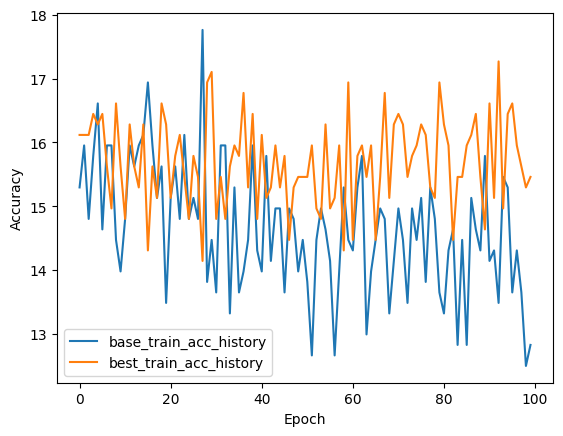

In [346]:
# Plot the accuracy curve
plt.plot(base_train_acc_history, label='base_train_acc_history')
plt.plot(best_train_acc_history, label='best_train_acc_history')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

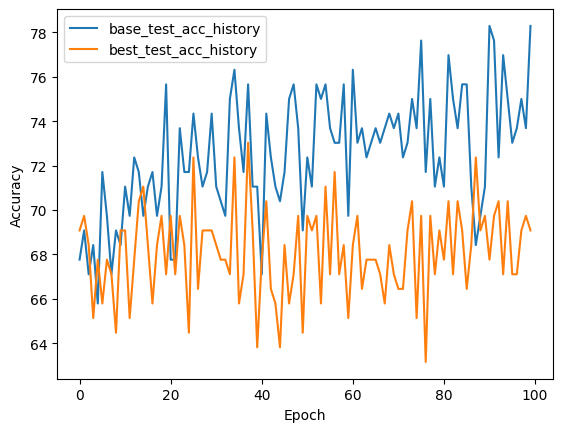

In [347]:
# Plot the accuracy curve
plt.plot(base_test_acc_history, label='base_test_acc_history')
plt.plot(best_test_acc_history, label='best_test_acc_history')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# References 

# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
# https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
# https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
# https://www.youtube.com/watch?v=jF43_wj_DCQ